# Introduction 


Using the jupyter notebook 1_combineCSVtoH5 you should now have a COMPAS output file in hdf5 format, e.g. with the name **COMPASOutput.h5**. This jupyter notebook is written for Luyao's project and will obtain the chirpmass distribution (with selection effects of the double compact type, and pessimistic/optimistic) for the new COMPAS code. The outcome of this jupyter notebook is a chirpmass distribution and an array of chirp masses.

# Import libraries 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
minor = AutoMinorLocator()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



# Set input

In [15]:
# path to hdf5 output file
pathCOMPASOutput = '/Users/floorbroekgaarden/Programs/newGithubCOMPAS/COMPAS/src/COMPAS_output.h5'

fdata = h5.File(pathCOMPASOutput)


# Obtain Chirp mass 



In [54]:
class postProcessingCOMPAS(object):

    
    
    def __init__(self, hdf5, DCOtype, boolDCOmask):
        """
        hdf5 = output file in hdf5 format
        DCOtype = 'BBH' / 'ALL' / 'BHNS' or 'BNS' 
        boolDCOmask = [Hubble, RLOF, Pessimistic] # boolean values whether to mask mergers in a Hubble time, 
        binaries that have RLOFSecondaryAfterCEE = True, and Pessimistic binaries (i.e. optimisticCEFlag == 0)      
        """
        self.hdf5 = hdf5  # 
        self.DCOtype = DCOtype
        self.boolDCOmask = boolDCOmask


        self.fDCO  = self.hdf5['DoubleCompactObjects']
        self.fSN   = self.hdf5['Supernovae']
        self.fCE  = self.hdf5['CommonEnvelopes']
        self.fSystems = self.hdf5['SystemParameters']
        self.totalSystems= len((self.hdf5['SystemParameters']['MZAMS_1'][...].squeeze()))

            
        
        
    def obtainData(self, param):
        """returns for STROOPWAFEL (AIS) simulation the data of wanted variable
        combines the data from AIS_oratory and AIS_sampling 

        param = [xparam, fxparam] ,  are the name of the variable header and hdf5 keyname where it is in
        e.g. param = ['MZAMS_1', 'DoubleCompactObjects'] (see also: print(list(fdata.keys())))
        """ 

        xparam, fxparam = param
        fAIS = self.hdf5
    
        

        ##### get parameter from two directories and combine them ############
        xvalues         = fAIS[fxparam][xparam][...].squeeze()
        return   xvalues



    def maskTarget(self):
        """returns mask of DCOs of interest
        """

        Hubble, RLOF, Pessimistic = self.boolDCOmask

                

        # mask binaries of given DCO type
        if self.DCOtype == 'BNS':
            mask0 = ((self.fDCO['Stellar_Type_1'][...] == 13) & (self.fDCO['Stellar_Type_2'][...] == 13))
        elif (self.DCOtype == 'BHNS') | (self.DCOtype == 'NSBH'):
            mask0 = ((self.fDCO['Stellar_Type_1'][...] == 13) & (self.fDCO['Stellar_Type_2'][...] == 14)) | \
                ((self.fDCO['Stellar_Type_1'][...] == 14) & (self.fDCO['Stellar_Type_2'][...] == 13) )          
        elif self.DCOtype == 'BBH':
            mask0 = ((self.fDCO['Stellar_Type_1'][...] == 14) & (self.fDCO['Stellar_Type_2'][...] == 14))
        elif (self.DCOtype == 'all') | (self.DCOtype == 'ALL') :
            mask0 = ((self.fDCO['Stellar_Type_1'][...] == 14) | (self.fDCO['Stellar_Type_1'][...] == 13))
        else:
            print('error: DCO type not known')

        # Hubble mask
        if Hubble:
            mask1 = (self.fDCO['Merges_Hubble_Time'][...]==True) 
        elif not Hubble:
            mask1 = (self.fDCO['Merges_Hubble_Time'][...]==True) |  (self.fDCO['Merges_Hubble_Time'][...]==False) 
        # RLOF mask
        if RLOF:
            mask2 = (self.fDCO['RLOF_Secondary>CE'][...]==False)
        elif not RLOF:
            mask2 = (self.fDCO['RLOF_Secondary>CE'][...]==False) | (self.fDCO['RLOF_Secondary>CE'][...]==True)
        # Pessimistic mask :  if True mask systems that have optimistic CE flag ==1
        if Pessimistic:
            mask3 = np.logical_not(self.fDCO["Optimistic_CE"][...] == 1)
        elif not Pessimistic:
            mask3 = np.logical_not(self.fDCO["Optimistic_CE"][...] == 1) + \
            np.logical_not(self.fDCO["Optimistic_CE"][...] == 0)   

                
        # combine the different masks and the oratory and refinement masks
        combinedmask = mask0 * mask1 * mask2 * mask3
        combinedmask = combinedmask.squeeze()


        return combinedmask





    def chirpmass(self, m1, m2):
        numer = (m1*m2)**(3/5)
        denom = (m1+m2)**(1/5)

        return numer/denom




    def obtainM1BHandM2BHassymetric(self, m1, m2):
        """returns ordered masses, where m1 will always be the most massive
        and m2 the least massive object of the binary"""
        m1bh, m2bh = np.zeros_like(m1), np.zeros_like(m1)
        maskm1heavier = ( m1 >= m2)
        maskm2heavier = (m1 < m2)

        m1bh[maskm1heavier] = m1[maskm1heavier] 
        m1bh[maskm2heavier] = m2[maskm2heavier]
        m2bh[maskm1heavier] = m2[maskm1heavier]
        m2bh[maskm2heavier] = m1[maskm2heavier]

        return m1bh, m2bh # m1bh has all the heaviest systems



        
        
    def getvariables(self, var_x, var_y):
        '''
        var_x = name of x variable we want to get (has to live in DCO file)
        var_y = name of y variable we want to get (has to live in DCO file)
        '''


        if self.metallicity:
            # mask specific requested metallicity  
            maskDCO_temp = self.maskTargetDCOsSTROOPWAFEL(self,\
                                                otherSelection=None, otherparam=None) 
            maskDCO = (self.fDCO['Metallicity1'][...].squeeze() == self.metallicity) & (maskDCO_temp == 1)

        else:
            #Only want selected DCO type (combines all metallicities & does not mask specific metallicity)
            maskDCO = self.maskTargetDCOsSTROOPWAFEL(self,\
                                                otherSelection=None, otherparam=None)


        #Because I dont want to retype the columns every time and I dont want 
        #all the data 
#             metallicities    = np.log10((fDCO['Metallicity1'][...][maskDCO].squeeze())/0.0142)
        varx             = self.fDCO[var_x][...][maskDCO].squeeze()
        vary             = self.fDCO[var_y][...][maskDCO].squeeze()



        return varx, vary




    




    
    





The following block prints the datafiles in the COMPAS hdf5 output files. In addition, it prints for the datafile 'DoubleCompactObjects' the header names of the parameters. <br>
These can be used as input in the variable **param = [headername, datafilename]** in the function below. 

In [25]:

print()
print('the hdf5 file contains the following datafiles:')
print(fdata.keys())

print()
print('The DoubleCompactObjects file contains the following parameter headers:')
print(fdata['DoubleCompactObjects'].keys())




the hdf5 file contains the following datafiles:
<KeysViewHDF5 ['CommonEnvelopes', 'DoubleCompactObjects', 'RLOF', 'Supernovae', 'SystemParameters']>

The DoubleCompactObjects file contains the following parameter headers:
<KeysViewHDF5 ['Binding_Energy@CE_1', 'Binding_Energy@CE_2', 'CEE', 'CE_Alpha', 'Coalescence_Time', 'Double_Core_CE', 'Eccentricity<2ndSN', 'Eccentricity<CE', 'Eccentricity>CE', 'Eccentricity@DCO', 'Eccentricity_0', 'Experienced_SN_Type_1', 'Experienced_SN_Type_2', 'ID', 'Kick_Velocity_1', 'Kick_Velocity_2', 'LBV_Multiplier', 'Lambda@CE_1', 'Lambda@CE_2', 'MT_Case_1', 'MT_Case_2', 'MZAMS_1', 'MZAMS_2', 'Mass_0_1', 'Mass_0_2', 'Mass_1', 'Mass_2', 'Mass_CO_Core@CE_1', 'Mass_CO_Core@CE_2', 'Mass_CO_Core@CO_1', 'Mass_CO_Core@CO_2', 'Mass_Core@CE_1', 'Mass_Core@CE_2', 'Mass_Core@CO_1', 'Mass_Core@CO_2', 'Mass_He_Core@CE_1', 'Mass_He_Core@CE_2', 'Mass_He_Core@CO_1', 'Mass_He_Core@CO_2', 'Mass_Total@CO_1', 'Mass_Total@CO_2', 'Merges_Hubble_Time', 'Metallicity_1', 'Metallici

In the following block we will as an example read in the final masses of all BH-BH mergers <br>
This is done by setting dcotype = 'BBH' to select this type of Double compact object merger (other options are "ALL" and "BNS" and "BHNS"  <br>
In addition, we want to only select mergers that   (1)  merge in a Hubble time, (2) are in binaries that have RLOFSecondaryAfterCEE = False (3) are Pessimistic binaries (i.e. optimisticCEFlag == 0) 
and we do this using boolDCOmask = [Hubble, RLOF, Pessimistic] = [(1), (2), (3)] = [1,1,1]


32


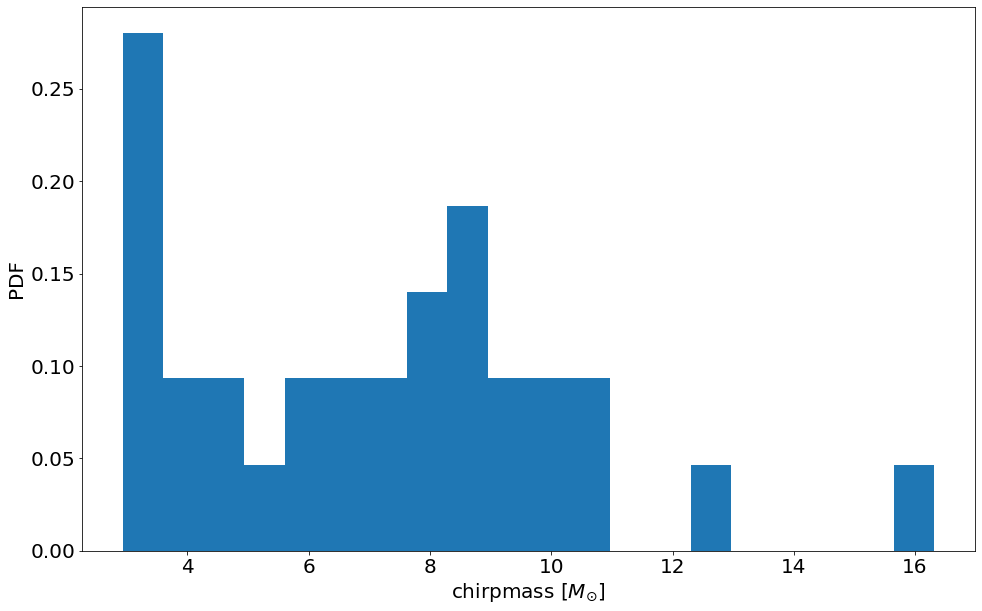

In [46]:



boolmask=[1,1,1]
dcotype = 'BBH'

ppCOMPAS = postProcessingCOMPAS(hdf5=fdata, DCOtype=dcotype, boolDCOmask=boolmask)

# read in parameters of interest:
xvar1, xvar2 = ppCOMPAS.obtainData(param=['Mass_1','DoubleCompactObjects']), ppCOMPAS.obtainData(param=['Mass_2','DoubleCompactObjects'])
DCOmask = ppCOMPAS.maskTarget()

# now use DCOmask to obtain the BH masses of our selection of BH-BH mergers
Mass_1_BBH, Mass_2_BBH = xvar1[DCOmask], xvar2[DCOmask]


# and use the chirpmass function to transform Mass_1 and Mass_2 into a chirpmass:
chirpmass_BBH = ppCOMPAS.chirpmass(Mass_1_BBH, Mass_2_BBH)
print(len(chirpmass_BBH))


# plot chirpmass distribution
f, ax= plt.subplots(ncols=1, nrows=1, figsize=(16,10))
fs=20
ax.hist(chirpmass_BBH, bins=20, lw=3, density=True)


ax.set_ylabel('PDF', fontsize=fs)
ax.set_xlabel('chirpmass [${M}_{\odot}$]', fontsize=fs)
ax.tick_params(labelsize=fs)
plt.show()





note the plot doesnt look so smooth, because the total nr of BH-BHs in this simulation is just 32 and very small. This is because I ran a low nr of binaries in this dataset <br>
You can set DCOmask = [0,1,1] to make it higher (and include also BH-BH systems that dont merge in a Hubble time)



# Obtain other parameters 

If you want to obtain other properties of the above selected BH-BH binaries, such as the initial masses you can do something similar to this using the unique SEED identifier to cross-match the datafiles:



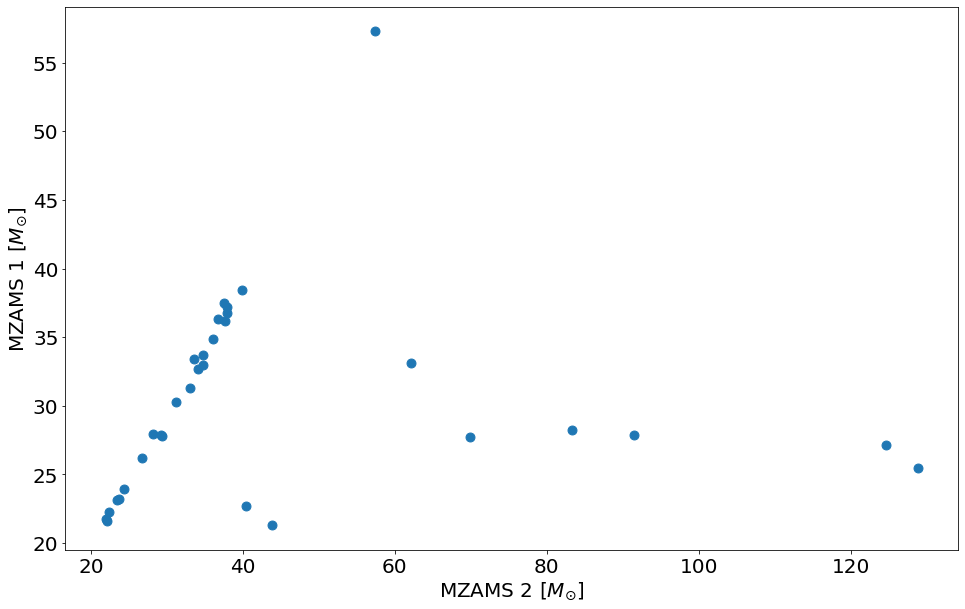

In [58]:



boolmask=[1,1,1]
dcotype = 'BBH'

ppCOMPAS = postProcessingCOMPAS(hdf5=fdata, DCOtype=dcotype, boolDCOmask=boolmask)

# read in parameters of interest:
xvar1, xvar2 = ppCOMPAS.obtainData(param=['MZAMS_1','SystemParameters']), ppCOMPAS.obtainData(param=['MZAMS_2','SystemParameters'])


DCOmask = ppCOMPAS.maskTarget()

#what are the seeds of the systems that form BBHs? First: obtain seeds from DoubleCompactObjects and systemParameters file
SEED_DCO, SEED_sys = ppCOMPAS.obtainData(param=['SEED','DoubleCompactObjects']), ppCOMPAS.obtainData(param=['SEED','SystemParameters'])
#Give me a bool of the lines in formation channels that form BBHs
# this is the cross matching of the datafiles, it makes one mask (bools) for the systemParameters data
SEED_BBH = SEED_DCO[DCOmask]
bools = np.in1d(SEED_sys, SEED_BBH)



# # now use DCOmask to obtain the BH masses of our selection of BH-BH mergers
MZAMS_1_BBH, MZAMS_2_BBH = xvar1[bools], xvar2[bools]



# plot birth masses of BH-BH that merge in a Hubble time, Pessimistic and have RLOFafterCEE==0 
f, ax= plt.subplots(ncols=1, nrows=1, figsize=(16,10))
fs=20
ax.scatter(MZAMS_1_BBH, MZAMS_2_BBH, s=80)


ax.set_ylabel('MZAMS 1 [${M}_{\odot}$]', fontsize=fs)
ax.set_xlabel('MZAMS 2 [${M}_{\odot}$]', fontsize=fs)
ax.tick_params(labelsize=fs)
plt.show()




